<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/9_Feature_engineer_select/9_5_PCA_sphereing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 9: Principles of Feature Engineering and Selection

This notebook contains interactive content from an early draft of the university textbook <a href="https://github.com/neonwatty/machine-learning-refined/tree/main">
Machine Learning Refined (2nd edition) </a>.

The final draft significantly expands on this content and is available for <a href="https://github.com/neonwatty/machine-learning-refined/tree/main/chapter_pdfs"> download as a PDF here</a>.

# 9.5  Feature Scaling via PCA-Sphering

In the [Section 9.3](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_3_Scaling.html) we saw how *feature scaling* via *standard normalization* - i.e., by subtracting off the mean of each input feature and dividing off its standard deviation - significantly improves the topology of a machine learning cost function enabling much more rapid minimization via first order methods like e.g., the generic gradient descent algorithm.  In this Section we describe how PCA is used to perform a more advanced form of standard normalization - commonly called *PCA sphereing* (also commonly referred to as *whitening*).  With this improvement on standard normalization we use PCA to rotate the mean-centered dataset so that its largest orthogonal directions of variance allign with the coordinate axes prior to scaling each input by its standard deviation.  This typically allows us to better compactify the data, resulting in a cost function whose contours are even more 'circular' than that provided by standard normalization and thus makes cost functions even easier to optimize.  

In [1]:
# install github clone - allows for easy cloning of subdirectories
!pip install github-clone
from pathlib import Path 

# clone images
if not Path('chapter_9_images').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/9_Feature_engineer_select/chapter_9_images
else:
    print('chapter_9_images already cloned!')

# image paths
image_path_1 = "chapter_9_images/standard_normal_vs_pca_sphereing.png"
image_path_2 = "chapter_9_images/standard_vs_sphereing_contours.png"
image_path_3 = "chapter_9_images/pca_sphereing.png"
    
# standard imports
import matplotlib.pyplot as plt
from matplotlib import gridspec
import IPython, copy
from IPython.display import Image, HTML

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
chapter_9_images already cloned!


## The PCA sphering scheme

Using the same notation as [Section 9.3](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_3_Scaling.html) we denote by $\mathbf{x}_p$ the $p^{th}$ input of $N$ dimensions belonging to some dataset of $P$ points.  By stacking these together column-wise we create our $N\times P$ data matrix $\mathbf{X}$.  We then denote $\frac{1}{P}\mathbf{X}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$ the regularized covariance matrix of this data and $\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T +\lambda \mathbf{I}_{N\times N}= \mathbf{V}^{\,}\mathbf{D}^{\,}\mathbf{V}^T$ its eigenvalue/vector decomposition (see [Section 8.5](https://jermwatt.github.io/machine_learning_refined/notes/8_Linear_unsupervised_learning/8_5_Classic.html)).

Now remember that when performing PCA we first *mean-center* our dataset (see Section 8.2) - that is we subtract off the mean of each coordinate (note how this is the first step in the standard normalization scheme as well).  We then aim to represent each of our mean-centered datapoints 
datapoint $\mathbf{x}_p$ by $\mathbf{w}_p = \mathbf{V}_{\,}^T\mathbf{x}_p^{\,}$.  In the space spanned by the principal components we can represent the entire set of transformed mean-centered data as 

\begin{equation}
\text{(PCA transformed data)}\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\mathbf{W} = \mathbf{V}^T\mathbf{X}^{\,}.
\end{equation}

With our data not rotated so that its largest orthogonal directions of variacne align with the coordinate axes, to *sphere* the data we simply divide off the standard deviation along each coordinate of the PCA-transformed (mean-centered) data $\mathbf{W}$. 

In other words, PCA-sphereing is simply the standard normalization scheme we have seen in the previous Section with a single step inserted in between mean centering and the dividing off of standard deviations: in between these two steps we rotate the data using PCA.  By rotating the data prior to scaling we can typically shrink the space consumed by the data considerably more than standard normalization, while simultaneously making any associated cost function considerably easier to minimize properly.

In the Figure below we show a generic comparison of how standard normalization and PCA sphereing affect a prototypical dataset, and its associated cost function.  Because PCA sphereing first rotates the data prior to scaling it typically results in more compact transformed data, and a transformed cost function with more 'circular' contours (which is easier to minimize via gradient descent).  

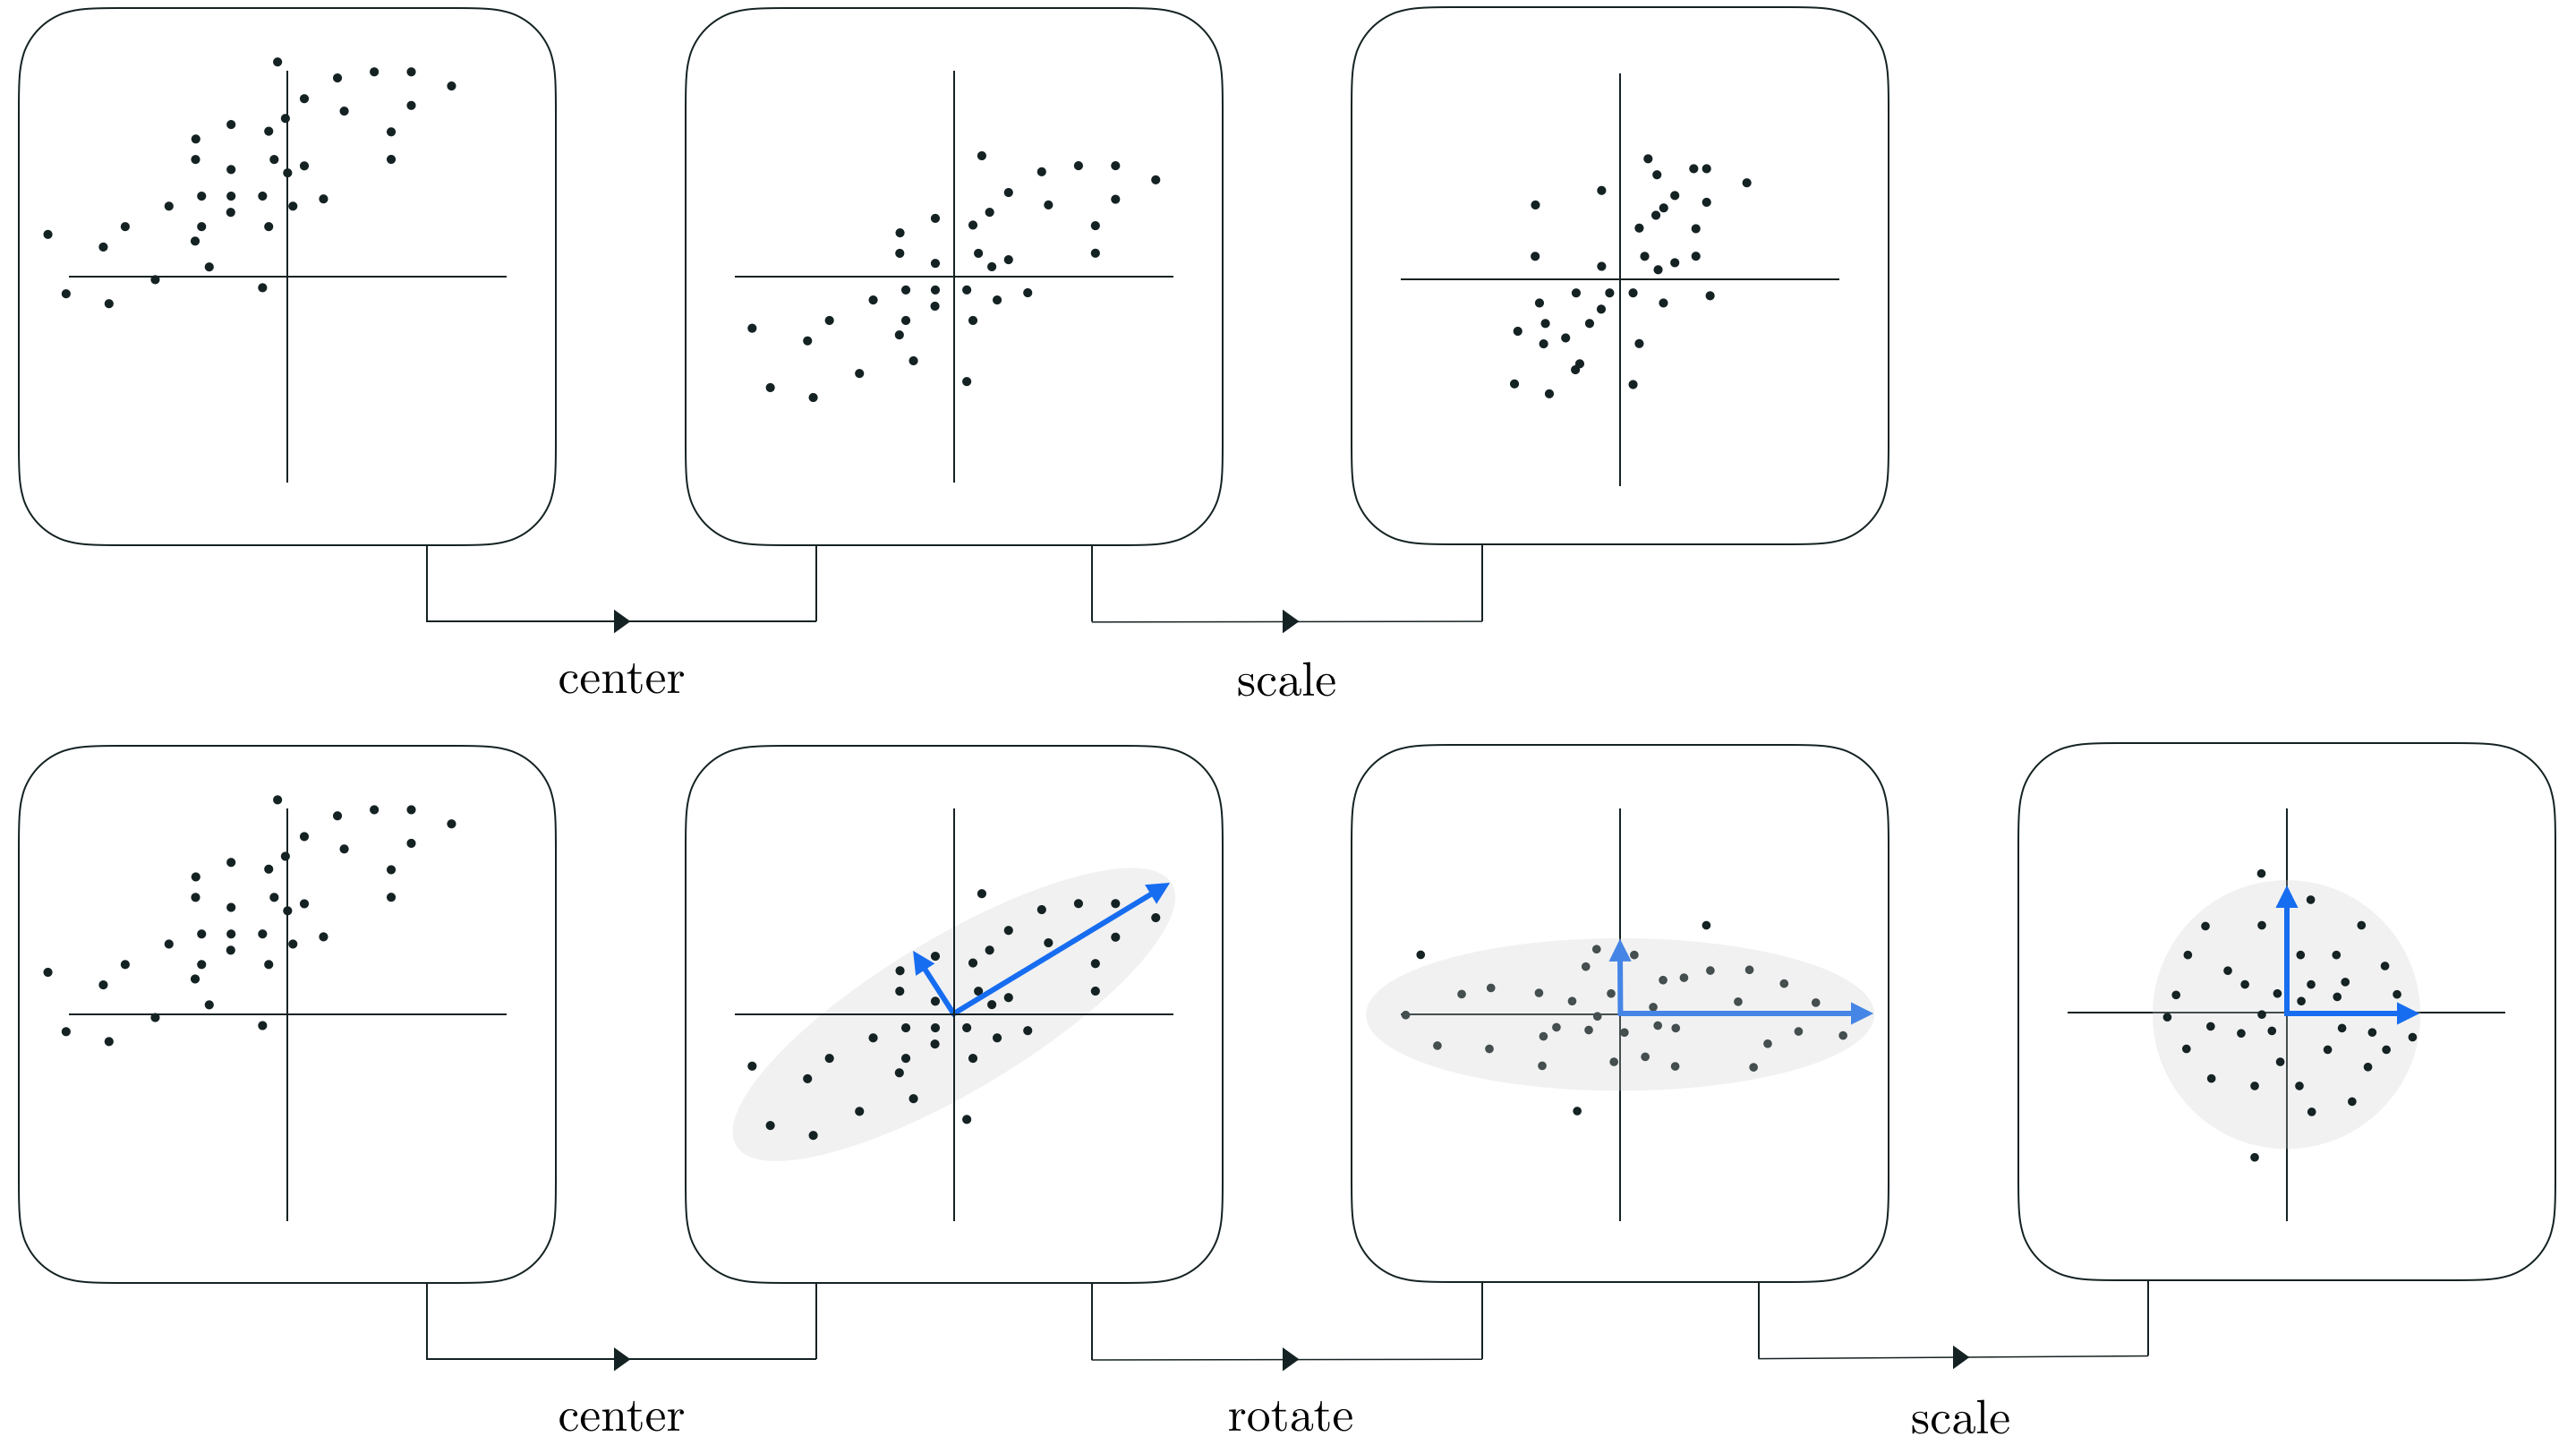

In [2]:
Image(image_path_1)

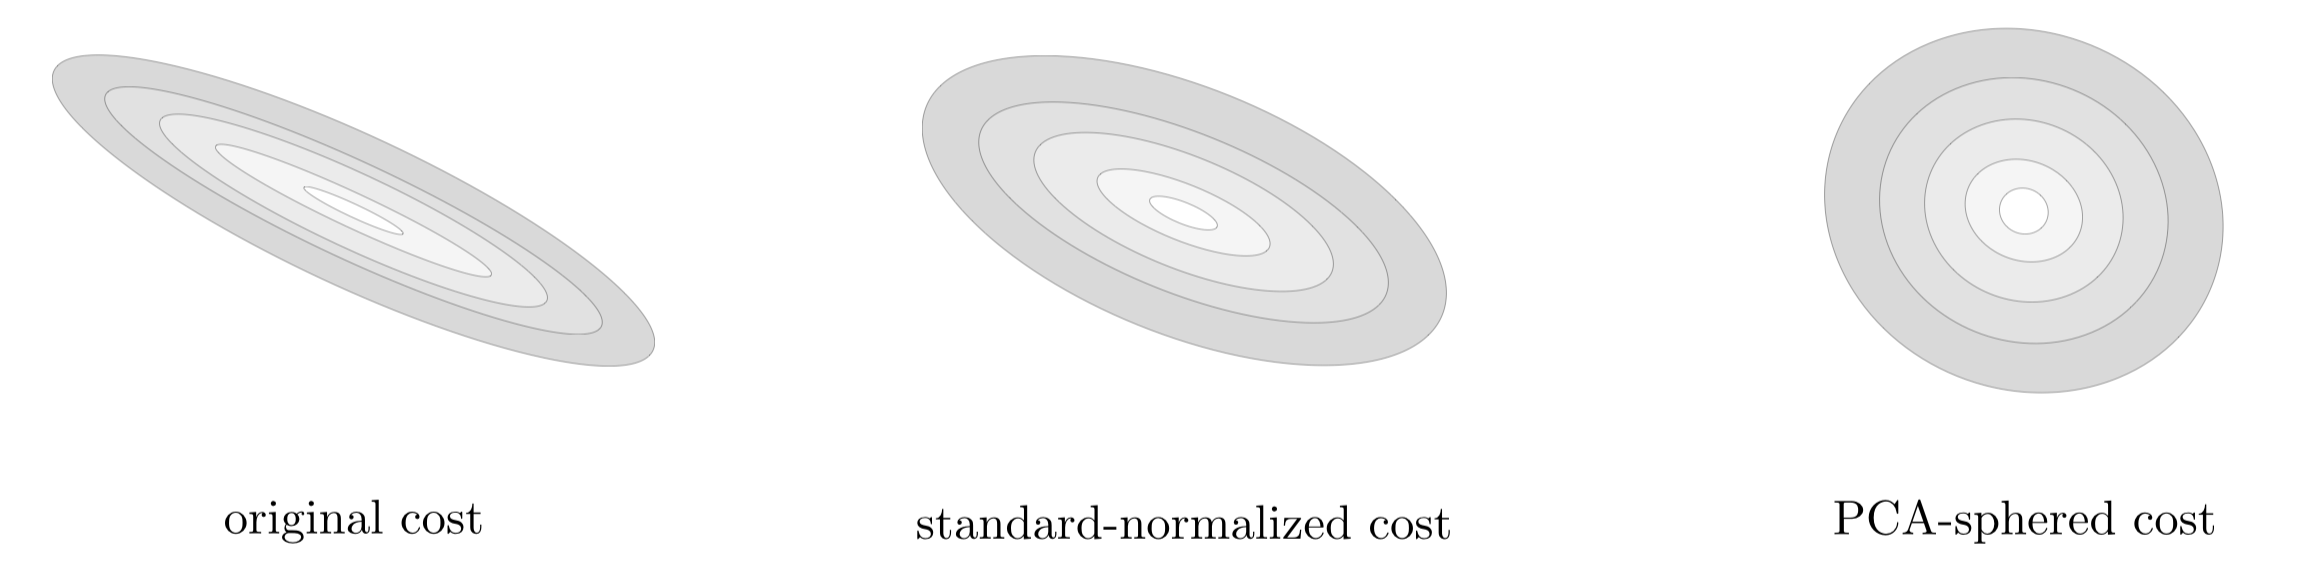

In [3]:
Image(image_path_2)

<figure>
  <figcaption>   
<strong>Figure 1:</strong> <em> The standard normalization procedure (top row) compared to PCA sphereing (middle row) on a generic dataset.  PCA sphereing is simply the standard normalization scheme with a single step inserted in between mean centering and the dividing off of standard deviations: in between these two steps we rotate the data using PCA.  By rotating the data prior to scaling we can typically shrink the space consumed by the data considerably more than standard normalization.  This tends to make any associated cost function considerably easier to minimize properly by better tempering its contours, making them more 'circular' (bottom row). </em>  </figcaption> 
</figure>

More formally if the *standard normalalization* scheme applied to a single datapoint $\mathbf{x}_p$ can be written in two steps as 

---
**Standard normalization scheme:**
1.  **(mean center)** for each $n$ replace $x_{p,n} \longleftarrow \left({x_{p,n} - \mu_n}\right)$ where $\mu_n = \frac{1}{P}\sum_{p=1}^{P}x_{p,n}$
2.  **(divide off std)** for each $n$ replace $x_{p,n} \longleftarrow \frac{x_{p,n}}{\sigma_n}$ where $\sigma_n = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_{p,n}\right)^2}$
---

The PCA-sphereing scheme can be then be written in three highly related steps as follows

---
**PCA-sphereing scheme:**
1.  **(mean center)** for each $n$ replace $x_{p,n} \longleftarrow \left({x_{p,n} - \mu_n}\right)$ where $\mu_n = \frac{1}{P}\sum_{p=1}^{P}x_{p,n}$
2.  **(PCA rotation)** transform $\mathbf{w}_p = \mathbf{V}_{\,}^T\mathbf{x}_p^{\,}$ where $\mathbf{V}$ is the full set of eignenvectors of the reguliarzed covariance matrix
3.  **(divide off std)** for each $n$ replace $w_{p,n} \longleftarrow \frac{w_{p,n}}{\sigma_n}$ where $\sigma_n = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(w_{p,n}\right)^2}$
---

## The PCA-sphering scheme expressed more elegantly 

Here we briefly describe how one can write the PCA-sphereing scheme more elegantly by leveraging our understanding of eigenvalue/vector decompositions.  This will result in precisely the same PCA-sphereing scheme we have seen previously, only written in a prettier / more elegant way mathematically speaking.  This also helps shed some light on the theoretical aspects of this normalization scheme.   However in wading through the mathematical details be sure not to lose the 'big picture' communicated previously: that PCA-sphereing is simply an extension of standard normalization where a PCA rotation is applied after mean centering and before dividing off standard deviations. 

Now, if we so choose we can express steps 2 and 3 of PCA-sphereing in a more mathematically elegant way using the *eigenvalues* of the regularized covariance matrix.  The Raleigh quotient definition of the $n^{th}$ eigenvalue $d_n$ of this matrix states that numerically speaking 

\begin{equation}
d_n = \frac{1}{P}\mathbf{v}_n \mathbf{X}_{\,}^{\,} \mathbf{X}_{\,}^T \mathbf{v}_n 
\end{equation}

where $\mathbf{v}_n$ is the $n^{th}$ and corresponding eigenvector.  Now in terms of our PCA transformed data this is equivalently written as

\begin{equation}
d_n = \frac{1}{P}\left\Vert \mathbf{v}_n^T \mathbf{X} \right \Vert_2^2 = {\frac{1}{P}\sum_{p=1}^{P}\left(w_{p,n}\right)^2}
\end{equation}

or in other words, it is the *variance* along the $n^{th}$ axis of the PCA-transformed data.  Since the final step of PCA-sphereing has us divide off the standard deviation along each axis of the transformed data we can then write it equivalently in terms of the eigenvalues as

---
3).  **(divide off std)** for each $n$ replace $w_{p,n} \longleftarrow \frac{w_{p,n}}{d_n^{1/_2}}$ where $d_n^{1/_2}$ is the square root of the $n^{th}$ eigenvalue of the regularized covariance matrix
 
 ---

Denoting $\mathbf{D}^{-1/_2}$ as the diagonal matrix whose $n^{th}$ diagonal element is $\frac{1}{d_n^{1/_2}}$, we can then (after mean-centering the data) express steps 2 and 3 of the PCA-sphereing algorithm very nicely as 

\begin{equation}
\text{(cleverly-written PCA-sphered data)}\,\,\,\,\,\,\,\,\, \mathbf{S}^{\,} = \mathbf{D}^{-^1/_2}\mathbf{W}^{\,} =  \mathbf{D}^{-^1/_2}\mathbf{V}^T\mathbf{X}^{\,}.
\end{equation}

While expressing PCA-sphereing in may seem largely cosmetic, notice that in the actual implementation (provided above) it is indeed computationally advantageous to simply use the eigenvalues in step 3 of the method (instead of re-computing the standard deviations along each transformed input axis) since we compute them anyway in performing PCA in step 2.

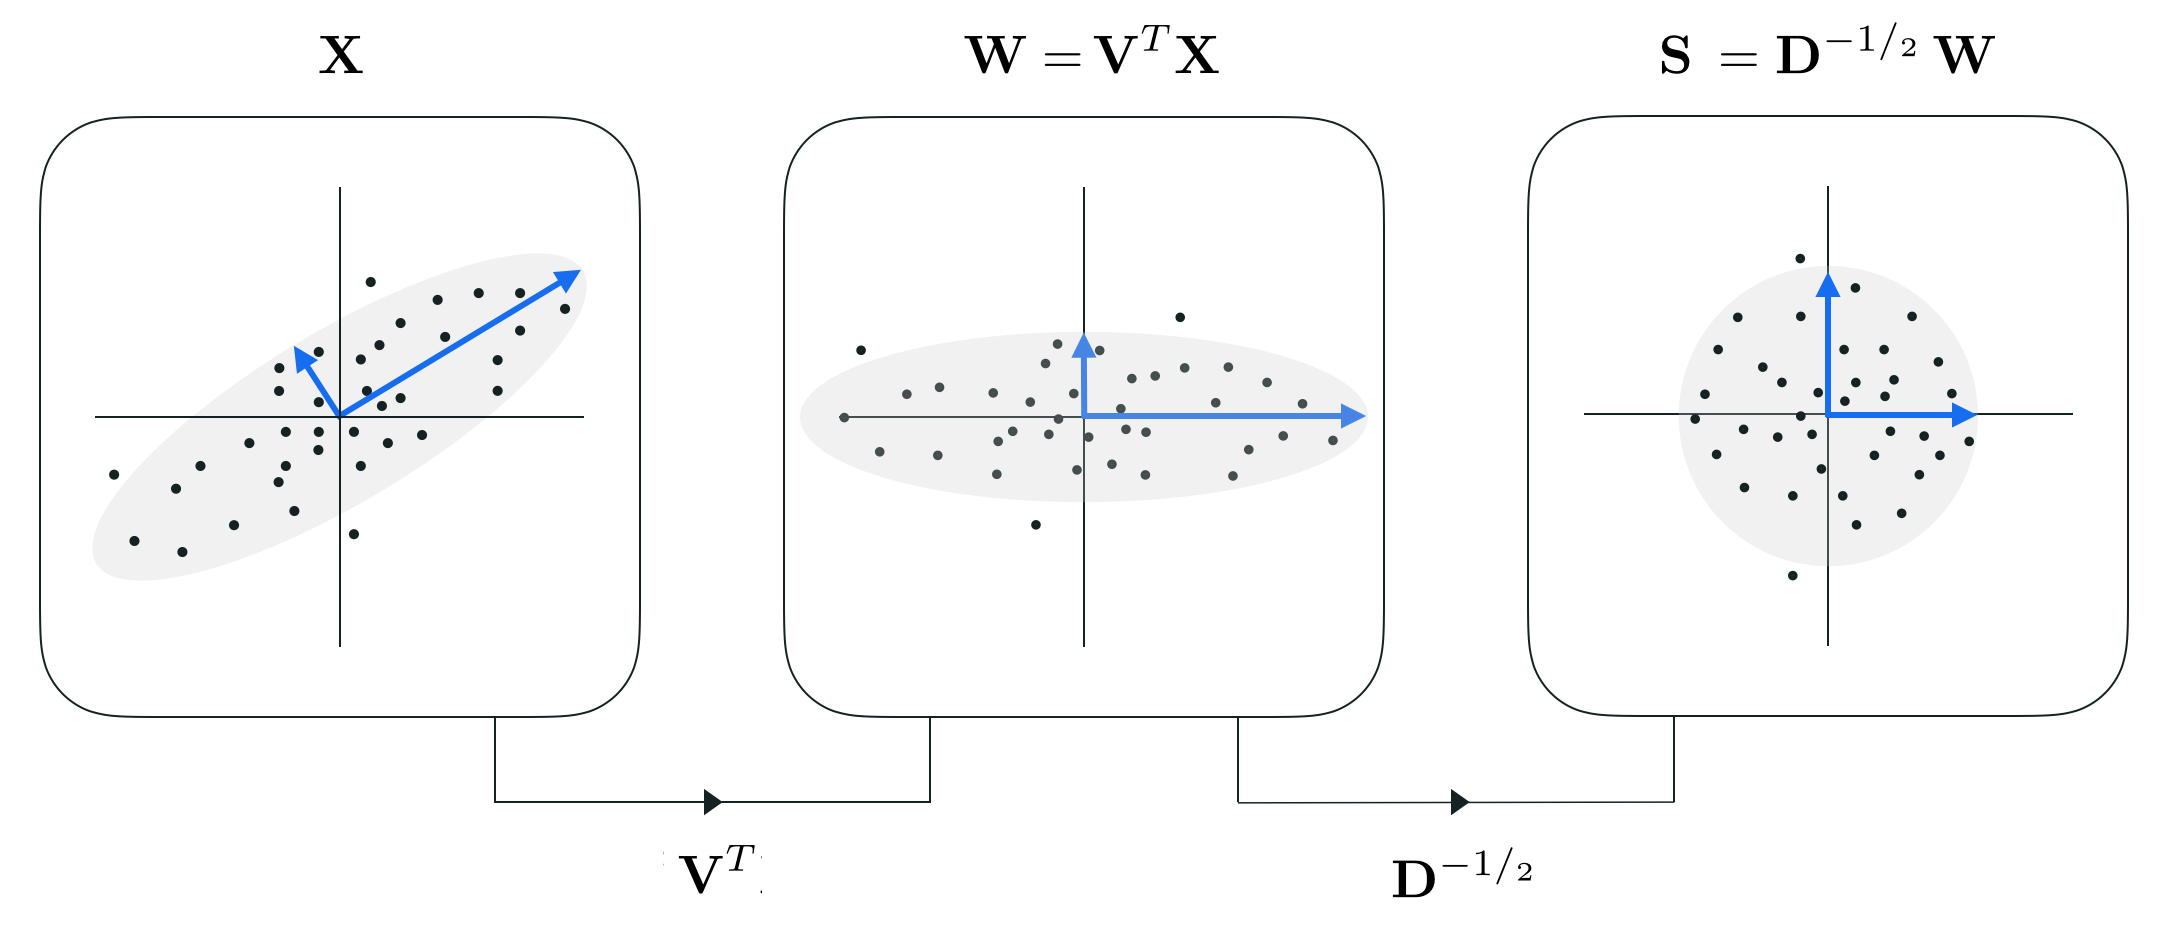

In [4]:
Image(image_path_3)

<figure>
  <figcaption>   
<strong>Figure 1:</strong> <em> PCA-sphereing illustrated. </em>  </figcaption> 
</figure>

Also notice that in writing the method this way we can see how - unlike the standard normalization scheme - in performing PCA sphereing we do truly 'sphere' the data in that 

\begin{equation}
 \frac{1}{P}\mathbf{S}^{\,}\mathbf{S}^T = \mathbf{I}_{N\times N}
\end{equation}

which can be easily shown by simply plugging in the definition of $\mathbf{S}$ and simplifying.  This implies that the contours of any cost function we have seen thus far tend to be highly *spherical*, e.g., in the case of a quadratic like Least Squares for linear regression are perfectly spherical, and thus will be much easier to optimize.